Importing the necessary libraries 

In [47]:
from tensorflow import keras
import cv2
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import pandas as pd

In [48]:
np.random.seed(42)

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading the dataset from the given path and calculating the size of the dataset

In [50]:
path = "/content/drive/MyDrive/Breast Cancer/Dataset_BUSI/Dataset_BUSI_with_GT"
dir_list = [os.path.join(path,i) for i in os.listdir(path)]
size_dict = {}
for i,value in enumerate(dir_list):
    size_dict[os.listdir(path)[i]] = len(os.listdir(value))
size_dict 

{'benign': 891, 'normal': 266, 'malignant': 421}

Defining a function to clean the data and remove any unnecessary characters from the dataset

In [51]:
import re
def clean(name):
    name = re.sub('[benign ().p]','',str(name))
    #print('###############')
    print(name)
    return name

In [52]:
#clean('Asif')

Creating a dataframe from the given dataset and storing the data in a list.

In [53]:
df = pd.DataFrame(os.listdir(dir_list[0]))
#print(df)
# df = df.apply(str,axis=1)
df = df[0].apply(clean)
# print(df.info())
df = df[~df.str.contains('mask',regex =False)]
df = df.apply(int)
df_list = list(df)
type(df_list)
df_list.sort()
#print(len(df_list))

123
183
191
122
116
124
11
107
187
177
131
121
132
101
113
105
184
125
129
189
103
110
128
120
115
114
106
130
117
126
186
173
190
176
182
185
188
13
193
181
174
127
118
179
178
112
171
108
1
12
111
10
100
104
180
102
119
175
192
109
172
247
248
238
239
284
250
216
26
25
22
278
286
293
275
298
260
246
306
23
271
232
300
257
217
261
258
301
302
211
288
264
3
228
291
283
209
231
307
263
235
28
272
290
208
299
279
210
259
30
233
254
304
241
287
15
242
270
243
265
230
285
218
227
296
207
244
24
273
277
280
262
245
223
234
310
18
240
309
213
237
294
219
221
212
251
274
308
20
305
303
220
266
14
252
282
16
17
214
224
255
222
229
268
236
2
226
19
297
267
295
215
27
21
289
225
281
276
292
269
253
249
31
256
206
29
381
390
325
375
380
333
372
320
329
364
373
393
374
394
331
354
356
314
385
337
321
368
32
358
313
360
367
350
363
324
335
392
382
347
366
38
378
336
37
348
355
318
33
377
330
343
315
39
388
389
312
316
341
35
317
384
36
311
342
334
369
387
361
383
322
386
332
346
362
379
353
34
370


In [54]:
dir_list[0]

'/content/drive/MyDrive/Breast Cancer/Dataset_BUSI/Dataset_BUSI_with_GT/benign'

Initializing the parameters for the model such as image size and channels

In [55]:
img_size = 128
img_channel = 3
X_b , Xm_b , y_b = np.zeros((437,img_size,img_size,img_channel)) , np.zeros((437,img_size,img_size,img_channel)) , np.full(437,'benign') 
X_n , Xm_n , y_n = np.zeros((133,img_size,img_size,img_channel)) , np.zeros((133,img_size,img_size,img_channel)) , np.full(133,'normal') 
X_m , Xm_m , y_m = np.zeros((210,img_size,img_size,img_channel)) , np.zeros((210,img_size,img_size,img_channel)) , np.full(210,'malignant')

Loading the images from the given path and adding them to the X_b, X_n, X_m array as benign, normal, malignant respectively.

If the images are masks then adding them to the Xm_b, Xm_n, Xm_m array as benign_mask, normal_mask, malignant_mask respectively.

In [56]:
import os
img1_path = os.path.join(os.path.join(path,'benign'),os.listdir(os.path.join(path,'benign'))[1])

pil_img = load_img(img1_path,color_mode = 'rgb',target_size=(img_size,img_size))
img = img_to_array(pil_img)
img_shape = img.shape
print(img_shape)

def img_num(filename):
    
    val = 0
    
    for i in range(len(filename)) :
        if filename[i] == '(' :
            while True :
                i += 1
                if filename[i] == ')' :
                    break
                val = (val*10) + int(filename[i])
            break
    
    return val

for tumor_path in dir_list :
    for image in os.listdir(tumor_path) :
        p = os.path.join(tumor_path, image)
        pil_img = load_img(p,color_mode = 'rgb',target_size=(img_size,img_size))         # read image as  grayscale ans resize it
        
        if image[-5] == ')' :                                   #if real image 
            
            if image[0] == 'b' :
                X_b[img_num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                               # to X as benign , normal
                X_n[img_num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[img_num(image)-1]+= img_to_array(pil_img)
        else :                                                 #else masked image
            
            if image[0] == 'b' :
                Xm_b[img_num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                               # mask to y.
                Xm_n[img_num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                Xm_m[img_num(image)-1]+= img_to_array(pil_img)

(128, 128, 3)


Combining the X, Xm, and y arrays into single arrays and normalizes the images by dividing by 255.

In [57]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
Xm = np.concatenate((Xm_b, Xm_n, Xm_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

print(X.shape)
print(Xm.shape)
print(y.shape)
X /= 255.0
Xm /= 255.0

print(X.max())
print(Xm.min())

(780, 128, 128, 3)
(780, 128, 128, 3)
(780,)
1.0
0.0


Using the Scikit-Learn library to split the dataset into training and testing sets, and then encodes the labels as one-hot vectors

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

encoder  = OneHotEncoder()
# y = y.toarray()
y=encoder.fit_transform(y.reshape(y.shape[0],1))

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.15,shuffle=True,random_state=42)
Xm_train,Xm_test,ym_train,ym_test = train_test_split(Xm,y,test_size = 0.15,shuffle=True,random_state=42,stratify=y.toarray())

class_list = encoder.categories_
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)
print(Xm_train.shape,Xm_test.shape)
print(ym_train.shape,ym_test.shape)

(663, 128, 128, 3) (117, 128, 128, 3)
(663, 3) (117, 3)
(663, 128, 128, 3) (117, 128, 128, 3)
(663, 3) (117, 3)


Defining a function for evaluating the model's performance based on different metrics

In [59]:
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,cohen_kappa_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix,classification_report

def evaluation(model,X_train,y_train,X_val,y_val,X_test,y_test,history):

    train_loss , train_acc = model.evaluate(X_train,y_train.toarray())
    val_loss, val_acc = model.evaluate(X_val,y_val.toarray())
    test_loss_value , test_accuracy = model.evaluate(X_test, y_test.toarray())
    y_pred = model.predict(X_test)
    y_pred_label = np.argmax(y_pred,axis=1)
    y_true_label = np.argmax(y_test,axis=1)
    cm = confusion_matrix(y_true_label, y_pred_label)
    print(cm)
    print(classification_report(y_true_label, y_pred_label))
    f1_measure = f1_score(y_true_label,y_pred_label,average='weighted')
    precisionScore=precision_score(y_true_label,y_pred_label,average='weighted')
    recallScore=recall_score(y_true_label,y_pred_label,average='weighted')
    roc_score = roc_auc_score(y_test.toarray(),y_pred)
    kappa_score = cohen_kappa_score(y_true_label,y_pred_label)

    print("Train accuracy = "+str(train_acc))
    print("Validation accuracy = "+str(val_acc))
    print('Test accuracy = ' + str(test_accuracy))
    print("F1 Score = "+str(f1_measure))
    print("Precision Score = "+str(precisionScore))
    print("Recall Score = "+str(recallScore))
    print("KAPPA = "+str(kappa_score))
    print("ROC Area = "+str(roc_score))


Defining a function to plot the model's training and validation accuracy and loss.

In [60]:
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()

Defining a function for fitting and evaluating the model.

In [61]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


def fit_evaluate(model,X_train,y_train,X_test,y_test,bs,Epochs,patience):
    es = EarlyStopping(monitor='val_loss', mode='min', patience=patience,restore_best_weights=True, verbose=1)
    X1_train,X_val,y1_train,y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=42,stratify = y_train.toarray())
    history = model.fit(X1_train,y1_train.toarray(),batch_size = bs,epochs=Epochs,validation_data = (X_val,y_val.toarray()), callbacks=[es])
    evaluation(model,X1_train,y1_train,X_val,y_val,X_test,y_test,history)
    Train_Val_Plot(history.history['acc'],history.history['val_acc'],history.history['loss'],history.history['val_loss'])

Loading the ResNet50 model and sets the layers as non-trainable.

In [62]:
import tensorflow as tf
base_model = tf.keras.applications.ResNet50(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=img_shape,
                pooling=None,
            )
for layer in base_model.layers:
    layer.trainable = False

Defining the ResNet50 model and compiles it using the Adam optimizer.

In [63]:
def resnet():
  
    model = Sequential()
    model.add(base_model)
   
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
    
    return model

Creating the model and training and evaluating it using the fit_evaluate function for the benign, normal, malignant images.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 32768)            131072    
 hNormalization)                                                 
                                                                 
 dense_20 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                      

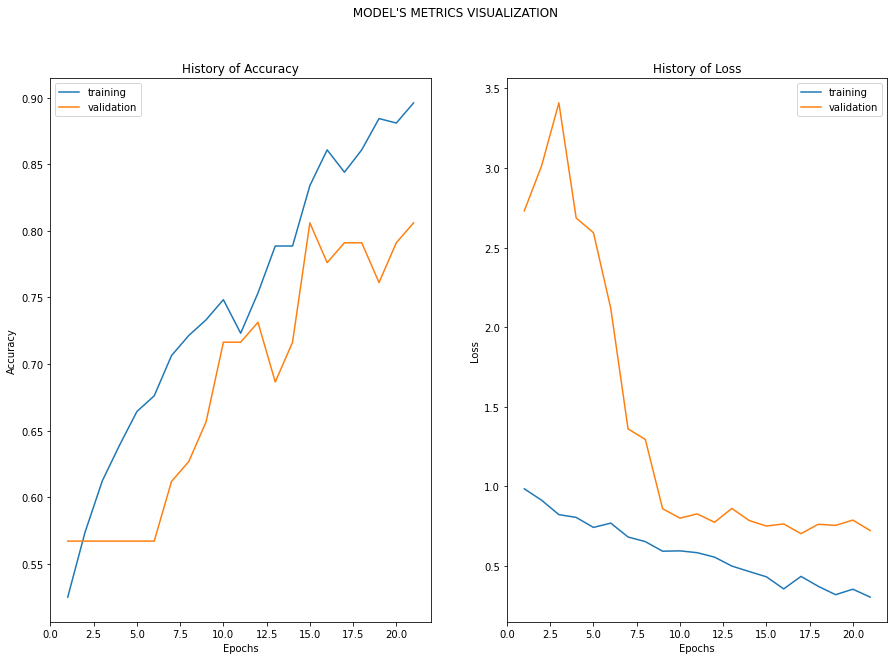

In [64]:
model = resnet()
model.summary()
fit_evaluate(model,X_train,y_train,X_test,y_test,20,30,4)

Creating the model and training and evaluating it using the fit_evaluate function for the benign_mask, normal_mask, malignant_mask images.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 batch_normalization_5 (Batc  (None, 32768)            131072    
 hNormalization)                                                 
                                                                 
 dense_25 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                      

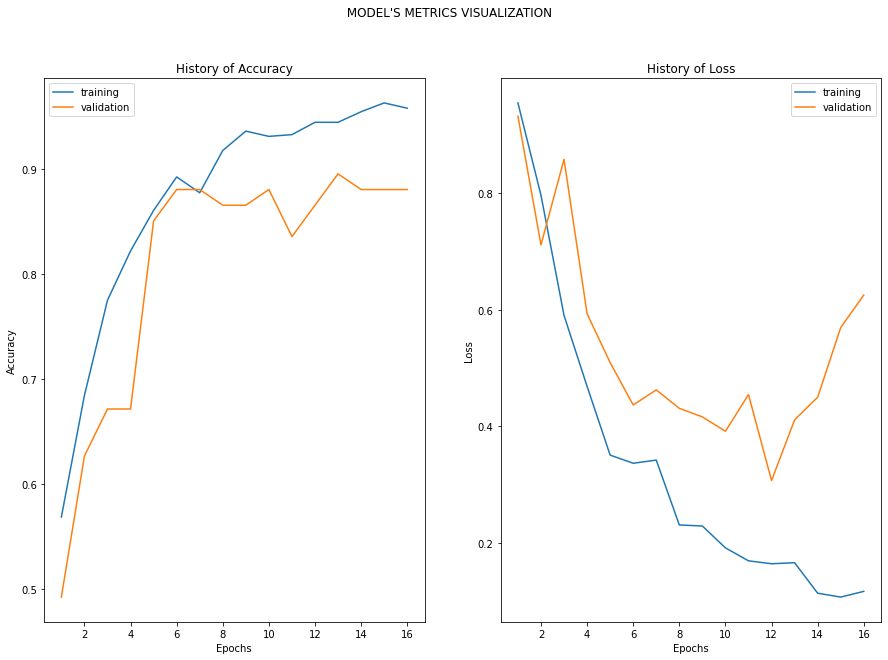

In [65]:
model = resnet()
model.summary()
fit_evaluate(model,Xm_train,ym_train,Xm_test,ym_test,20,30,4)